In [1]:
import pandas as pd
import quandl
import math

import numpy as np
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [225]:
# getting data for BTC stock from quandl
quandl.ApiConfig.api_key = 'tCYts9m9cqo4yDkwyAym'
df = quandl.get('BCHARTS/LOCALBTCINR')

In [226]:
# just viewing the table
df.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2019-01-04,283000.02,3333600.02,250499.21,286154.80,34.600636,9.710059e+06,280632.391138
2019-01-05,295500.06,2222222.22,260861.91,266925.20,36.729558,1.032165e+07,281017.626914
2019-01-06,274000.00,2333286.67,238099.50,305058.48,24.702179,6.990754e+06,283001.519654
2019-01-07,296900.01,2222222.22,260000.00,304673.69,39.296291,1.144308e+07,291200.111587
2019-01-08,286101.03,389153.51,272407.01,294498.76,16.707677,4.797441e+06,287139.883396


In [227]:
# picking relevant columns from the downloaded dataframe

df = df[['High','Low','Open','Close', 'Volume (BTC)']]

# adding a metric: High-Low Percent
df ['HL_PCT'] = ((df['High'] - df['Low']) / df['Low']) * 100

# adding a metric: Percent Change
df ['CHANGE_PCT'] = ((df['Close'] - df['Open']) / df['Open']) * 100

df.head(20)

,High,Low,Open,Close,Volume (BTC),HL_PCT,CHANGE_PCT
Date,,,,,,,
2013-03-20,3914.72,3737.39,3737.39,3914.72,3.0000,4.744755,4.744755
2013-03-21,4256.23,4256.23,4256.23,4256.23,2.3495,0.000000,0.000000
2013-03-22,0.00,0.00,0.00,0.00,0.0000,NaN,NaN
2013-03-23,4393.31,4393.31,4393.31,4393.31,2.2500,0.000000,0.000000
2013-03-24,4455.18,4455.18,4455.18,4455.18,0.2245,0.000000,0.000000
2013-03-25,4741.71,4680.28,4680.28,4741.71,2.6597,1.312528,1.312528
2013-03-26,0.00,0.00,0.00,0.00,0.0000,NaN,NaN
2013-03-27,5740.19,5740.19,5740.19,5740.19,0.7500,0.000000,0.000000
2013-03-28,0.00,0.00,0.00,0.00,0.0000,NaN,NaN


In [196]:
# discarding colums that have been used for the metrics and are no longer needed.
df = df[['Close', 'HL_PCT', 'CHANGE_PCT', 'Volume (BTC)']]


# The column that we wan't our model to predict/forcast
forecast_column = 'Close'

# Data Cleaning : replacing all "na" values
df.fillna('-99999', inplace=True)

In [197]:
# How many enteries ahead do we wan't to forecast
# forecast_out = int(math.ceil(0.1 * len(df)))
forecast_out = 1

# we create a label column that is actually the forecast_column but forecast_out days into the future.
df['label'] = df[forecast_column].shift(-forecast_out)

df[['Close',"label"]].tail(15)

,Close,label
Date,,
2018-12-25,268625.87,288500.04
2018-12-26,288500.04,277700.02
2018-12-27,277700.02,338000.97
2018-12-28,338000.97,275428.04
2018-12-29,275428.04,271600.00
2018-12-30,271600.00,295573.35
2018-12-31,295573.35,288789.98
2019-01-01,288789.98,277300.05
2019-01-02,277300.05,293928.94


In [100]:
# now since we added labels as a shift, we will have rows that have no labels. These will be the last forecast_out rows.
# here we are dropping these rows. These rows ain't loyal.
df.dropna(inplace=True)

# if we didn't drop the rows without labels earlier using dropna, this line could be used to do that.
# X = X[:-forecast_out + 1]

df[['Close',"label"]].tail(15)

,Close,label
Date,,
2018-12-24,307812.43,268625.87
2018-12-25,268625.87,288500.04
2018-12-26,288500.04,277700.02
2018-12-27,277700.02,338000.97
2018-12-28,338000.97,275428.04
2018-12-29,275428.04,271600.00
2018-12-30,271600.00,295573.35
2018-12-31,295573.35,288789.98
2019-01-01,288789.98,277300.05


<AxesSubplot:xlabel='Date'>

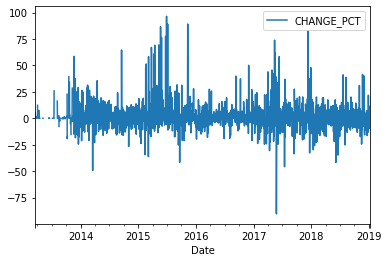

In [250]:
df[["CHANGE_PCT"]].plot()

In [199]:
import seaborn as sns
def facet_grid(feature:str, train):
    facet = sns.FacetGrid(train,aspect=4)
    facet.map(sns.kdeplot,feature,shade= True)
    facet.set(xlim=(0, (train[feature].max())))
    facet.add_legend()
    plt.show()

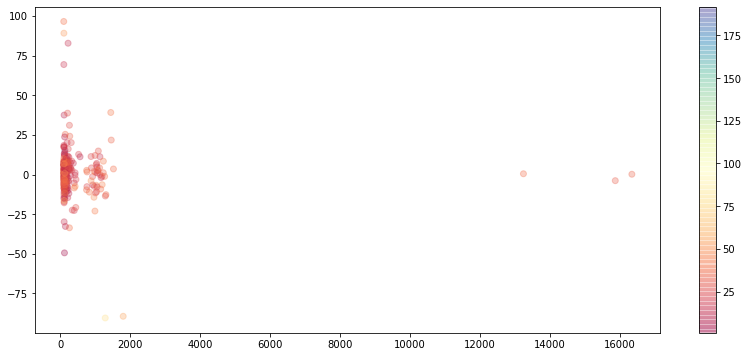

,High,Low,Open,Close,Volume (BTC),HL_PCT,CHANGE_PCT
Date,,,,,,,
2014-03-17,81063.73,37081.70,41371.52,41667.99,0.8756,118.608451,0.716604
2014-03-18,80225.47,36281.80,80225.47,40592.59,1.2356,121.117668,-49.401867
2014-07-28,78319.87,34467.47,35470.09,36293.25,8.6605,127.228369,2.320716
2014-08-22,64516.13,28965.69,29699.41,29083.33,2.9703,122.732930,-2.074385
2015-01-24,16431.15,100.00,15748.03,15772.87,33.8356,16331.150000,0.157734


In [243]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
# df1=df
df1 = df.loc[(df["HL_PCT"]>100) & (df["HL_PCT"]<200100)]
# plt.scatter(df1.index,df1["CHANGE_PCT"], c = df1["Volume (BTC)"], alpha = 0.3, cmap = "Spectral")
plt.scatter(df1["HL_PCT"], df1["CHANGE_PCT"], c = df1["Volume (BTC)"], alpha = 0.3, cmap = "Spectral")

plt.colorbar()

plt.show()
df1.head()

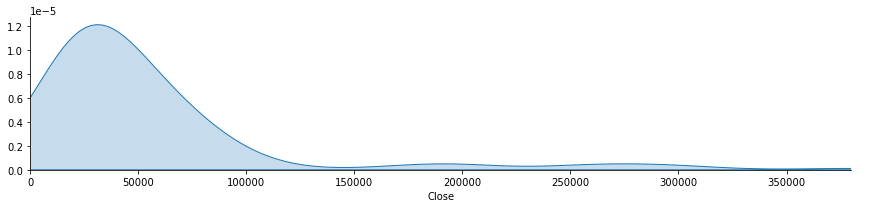

In [206]:
facet_grid("Close",df.loc[df["Volume (BTC)"]>50])

In [209]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2121 entries, 2013-03-20 to 2019-01-08
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         2121 non-null   float64
 1   HL_PCT        2121 non-null   object 
 2   CHANGE_PCT    2121 non-null   object 
 3   Volume (BTC)  2121 non-null   float64
 4   label         2120 non-null   float64
dtypes: float64(3), object(2)
memory usage: 99.4+ KB


,Close,Volume (BTC),label
count,2.121000e+03,2121.000000,2.120000e+03
mean,1.621137e+05,22.950751,1.621883e+05
std,2.508120e+05,20.456155,2.508476e+05
min,0.000000e+00,0.000000,0.000000e+00
25%,2.067312e+04,6.844900,2.072845e+04
50%,3.968784e+04,19.180700,3.969307e+04
75%,2.019931e+05,33.169235,2.019973e+05
max,1.999880e+06,191.719700,1.999880e+06


In [117]:
# print(forecast_out)

X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])

X = preprocessing.scale(X)


# print(len(X), len(y))

# now we will split out data into training and testing data.
# test_size defines what portion of the data we want to use for testing,
# the train-test-split function randomly will pick out test_size portion of entries.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

clf = LinearRegression()
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test);

print(accuracy)



0.946344399745117


AttributeError: 'DatetimeIndex' object has no attribute 'head'